# View QRNN predictions

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import os
from datetime import datetime
import argparse
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../visualize')
from sample_plots import plotRandomSample
sys.path.append('../src')

from quantnn.qrnn import QRNN
from quantnn.models.pytorch.logging import TensorBoardLogger
from quantnn.metrics import ScatterPlot
from load_data import GOESRETRIEVALSDataset, Mask, RandomSmallVals, RandomCrop, Standardize, ToTensor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)

device:  cpu


In [2]:
f = open('../path_to_data.txt', "r")
path_to_dataset = os.path.join(f.readline().rstrip("\n"))
f.close() 

In [3]:
def importData(BATCH_SIZE, path_to_data, path_to_stats, channel_inds, isTrain=False):

	transforms_list = [Mask(), RandomSmallVals()]
	if isTrain:
		transforms_list.append(RandomCrop(128))
	transforms_list.extend([Standardize(path_to_stats, channel_inds), ToTensor()])
	
	dataset = GOESRETRIEVALSDataset(
		path_to_data=path_to_data, 
		channel_inds=channel_inds,
		transform=transforms.Compose(transforms_list))
	print('number of samples:', len(dataset))

	#dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
	return(dataset)#, dataloader)

In [4]:
channel_inds = list(range(0,8))
CHANNELS = list(range(8,17))
CHANNELS.remove(12)
channels = [CHANNELS[c] for c in channel_inds]

path_to_val_data_files = os.path.join(path_to_dataset,'data/dataset-boxes/validation/npy_files/')
path_to_stats =  os.path.join(path_to_dataset, 'data', 'stats.npy')
    
validation_dataset  = importData(None, path_to_val_data_files, path_to_stats, channel_inds)

number of samples: 1354


In [6]:
data_type = 'boxes'
path_to_model = '../results/models/xception64_[100]_0.01__boxes_100_0.01_0_t5412_v1354[0, 1, 2, 3, 4, 5, 6, 7]_Adam_1622288705.386947.pckl'
qrnn = QRNN.load(path_to_model)
BATCH_SIZE = 64

'/export/home/ingrid/Dendrite/UserAreas/Ingrid/data/dataset-boxes/validation/npy_files/GPMGOES-oS2018-02-19T04:03:33-c[8,9,10,11,13,14,15,16]-p256-b-1.npy'

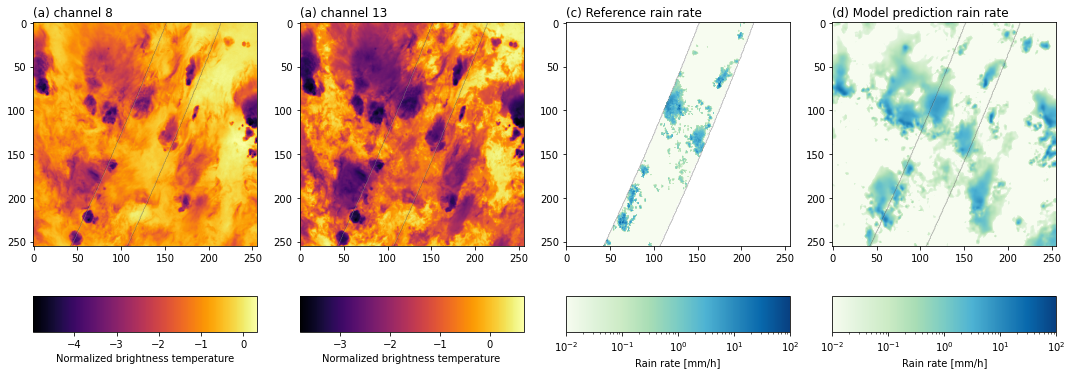

In [7]:
# PLOT RANDOM SAMPLE
idx = plotRandomSample(validation_dataset, channels, qrnn=qrnn, data_type=data_type)
validation_dataset.getfilename(idx)

In [8]:
data_type = 'singles'
path_to_model = '../results/models/singles_fc32786_[100]_0.001__singles_100_0.001_0_t83360758_v20805499[0, 1, 2, 3, 4, 5, 6, 7]_Adam_1622293711.867882.pckl'    
qrnn = QRNN.load(path_to_model)
BATCH_SIZE = 32786

'/export/home/ingrid/Dendrite/UserAreas/Ingrid/data/dataset-boxes/validation/npy_files/GPMGOES-oS2018-02-19T04:03:33-c[8,9,10,11,13,14,15,16]-p256-b-1.npy'

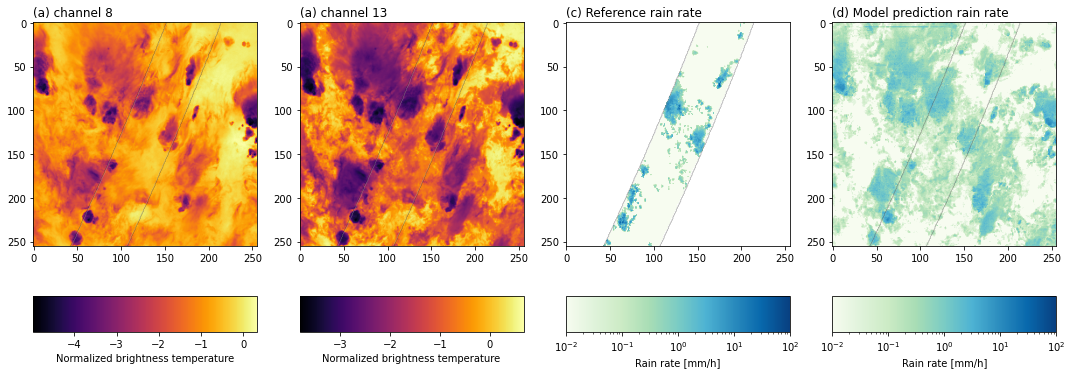

In [9]:
# PLOT RANDOM SAMPLE
idx = plotRandomSample(validation_dataset, channels, qrnn=qrnn, index=idx, data_type=data_type)
validation_dataset.getfilename(idx)

In [16]:
print((validation_dataset[1]['box']).dtype)

torch.float32
